In [1]:
import numpy as np
import numpy.random as np_rand
import scipy.special as sc
import matplotlib.pyplot as plt
from sklearn.mixture import BayesianGaussianMixture
from scipy.io import arff
from numpy.lib.recfunctions import structured_to_unstructured
from timeit import default_timer


## Simulated data

In [2]:
# Define parameters
k = 20 # truncation level for truncated drichlet process
alpha = 5 # concentration parameter for DP
n_samples = 100 # Number of X sample points to generate
num_of_gaussian_dim = 2 # Number of dimensions in Gaussian distribution from which X will be sampled
rho = 0.8 # first-order autocorrelation coefficient for covariance matrix of Gaussian distribution from which X will be sampled
variance_prior = 100 # variance of Gaussian baseline distribution in DP
variance_sample = 4 # variance of the gaussion from which X will be sampled


In [3]:
# Generate the baseline 2-dim Gaussion distribution prior of DP
base_mean = np.zeros(num_of_gaussian_dim) # zero-mean Gaussian
base_cov = np.eye(num_of_gaussian_dim) * variance_prior # scaled for comparison across dimensions (values should be of similar order)

#base_cov = [[100, 0], [0, 100]]
print("base_mean: \n", base_mean)
print("base_cov: \n", base_cov)

base_mean: 
 [0. 0.]
base_cov: 
 [[100.   0.]
 [  0. 100.]]


In [4]:
# Generate eta from baseline distribution of DP (Unique values of means(each per dim) from the 2-dim gaussion prior distribution of DP)
eta_params = np_rand.multivariate_normal(base_mean, base_cov, size=k)
#means = norm.rvs(base_mean, base_cov) # draw normal random variables for means
print("eta_params:\n", eta_params)

eta_params:
 [[ -7.17183245   0.37804454]
 [  7.27189012  -6.14298667]
 [ -1.09779332  -4.42250642]
 [  3.96046641 -22.8800051 ]
 [ -0.76533429   9.77043133]
 [ -2.18096905  -7.50882637]
 [  1.85883924   5.46306381]
 [-14.58299241  -3.57037449]
 [ 17.37663238 -20.67097517]
 [ -7.67427923   0.852338  ]
 [ -2.79424883  19.06347728]
 [  5.47732314 -13.19887931]
 [ 13.14879105   6.96234912]
 [ 11.17777756  -6.39162873]
 [ 12.66800237   2.90568103]
 [  1.30697182  -3.88809039]
 [  6.14508477  -4.09299631]
 [-10.32224555  -4.17066537]
 [  3.38512301  -0.30744748]
 [-18.48287643 -10.21886635]]


In [5]:
# DP using stick-breaking technique
V_params = np_rand.beta(1, alpha, size=k)
V_params[k-2] = 1 #Truncate DP construction at K by setting V_K-1 = 1, but in our case k index start from 0
print("V_params:\n ", V_params)

theta_params = np.zeros(k) # initialize the theta_params
remaining_stick = 1 # initialize the remaining stick length
for i in range(k):
    theta_params[i] = V_params[i] * remaining_stick # break the stick
    remaining_stick *= (1 - V_params[i]) # update the remaining stick length
print("theta_params:\n ", theta_params)

V_params:
  [0.09934981 0.05439106 0.1548675  0.34559859 0.19103494 0.11065527
 0.02930197 0.24519217 0.09331958 0.03115247 0.15408379 0.00933141
 0.03181836 0.12771681 0.17689164 0.21352939 0.00730155 0.38860866
 1.         0.04249642]
theta_params:
  [0.09934981 0.04898732 0.1318949  0.24875079 0.08998073 0.04216369
 0.00992964 0.08065427 0.02317021 0.007013   0.03360654 0.00172164
 0.00581568 0.02260099 0.02730513 0.02713011 0.00072961 0.03854839
 0.06064752 0.        ]


In [6]:
# Generate the first-order autocorrelation fixed covariance matrix of Gaussian distribution from which X will be sampled
cov = np.zeros((num_of_gaussian_dim, num_of_gaussian_dim)) # initialize the covariance matrix
for i in range(num_of_gaussian_dim):
    for j in range(num_of_gaussian_dim):
            cov[i, j] = variance_sample*(rho ** abs(i - j)) # assign the value based on the distance

#cov = [[3, 0.95], [0.95, 3]]
print('cov matrix: \n', cov)

cov matrix: 
 [[4.  3.2]
 [3.2 4. ]]


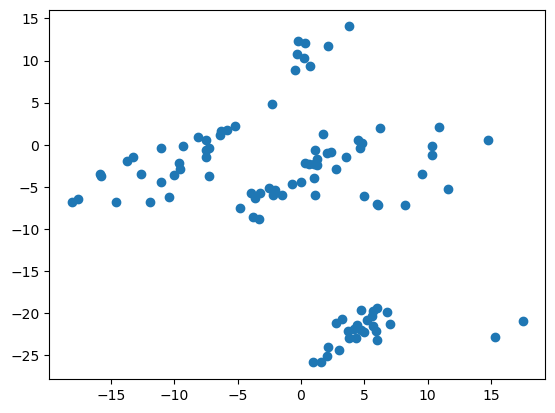

In [7]:
# Generate the samples from the Gaussion-Gaussion distribution
samples = np.zeros((n_samples, num_of_gaussian_dim)) # initialize the data matrix
z_params = np.zeros(n_samples, dtype=int) # initilize the z parameter

for i in range(n_samples):
    z_params[i] = np_rand.choice(k, p=theta_params) # assign a cluster to each sample point
    samples[i] = np_rand.multivariate_normal(eta_params[z_params[i]], cov) # draw a Sample point from the assigned cluster

# print("Samples: \n", samples)
plt.scatter(samples[:,0],samples[:,1])

In [8]:
import itertools
import matplotlib as mpl
from scipy import linalg

color_iter = itertools.cycle(["navy", "c", "cornflowerblue", "gold", "darkorange"])

def plot_results(X, Y_, means, covariances, title):
    """
    Plot gaussian components as ellipses
    """
    splot = plt.subplot(1, 1, 1)
    for i, (mean, covar, color) in enumerate(zip(means, covariances, color_iter)):
        # covar = np.diag(covar)
        v, w = linalg.eigh(covar)
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], 0.8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180.0 * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], angle=180.0 + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)
    plt.title(title)

In [9]:
# The scipy BGM do not provide a variance-fixed gaussian component option. 
bgm = BayesianGaussianMixture(n_components=k, weight_concentration_prior=None, n_init=1, covariance_type="full", max_iter=1000, verbose=2)
bgm.fit(samples)

Initialization 0
  Iteration 10	 time lapse 0.09899s	 ll change 2.94477
  Iteration 20	 time lapse 0.01601s	 ll change 0.00596
  Iteration 30	 time lapse 0.01600s	 ll change 0.00529
  Iteration 40	 time lapse 0.01701s	 ll change 0.00619
  Iteration 50	 time lapse 0.01700s	 ll change 0.00923
  Iteration 60	 time lapse 0.01600s	 ll change 0.01887
  Iteration 70	 time lapse 0.01700s	 ll change 0.07116
  Iteration 80	 time lapse 0.01701s	 ll change 1.07100
Initialization converged: True	 time lapse 0.22402s	 ll -645.40940


BayesianGaussianMixture(max_iter=1000, n_components=20, verbose=2)

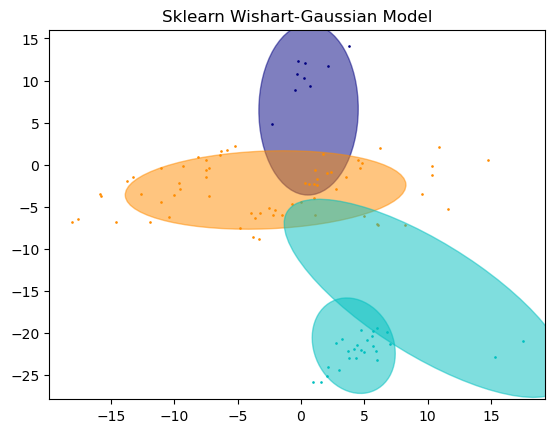

In [10]:
plot_results(samples, bgm.predict(samples), bgm.means_, bgm.covariances_, "Sklearn Wishart-Gaussian Model")

Converge at iter 19


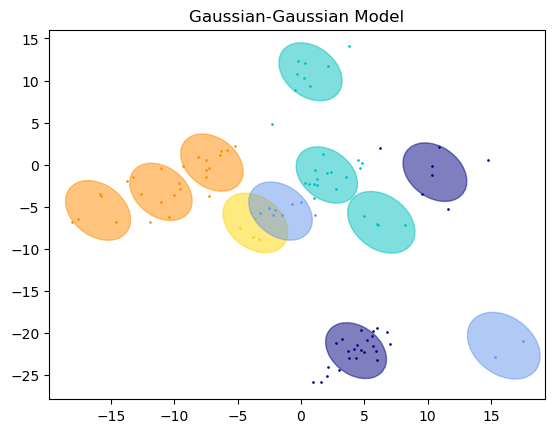

In [16]:
# Our model assume a fixed covariance in each component
from dp import *

eps = 1e-3
cov_samples = np.cov(samples.T)
mu_samples = np.mean(samples, axis=0)

# Initialization
dp = DpGaussian(samples, alpha=1e0, Sigma=cov_samples / k, mu0=mu_samples, Sigma0=cov_samples, K=k)
elbo = - np.inf

# CAVI update
for i in range(100):
    prev_elbo = elbo
    dp.update()
    elbo = dp.elbo()
    if elbo - prev_elbo < eps:
        print("Converge at iter", i)
        break

prob = dp.predict(samples)
label = np.argmax(prob, axis=1)
plot_results(samples, label, dp.mu_p, dp.Sigma + dp.Sigma_p, "Gaussian-Gaussian Model")

In [12]:
def plot_contour(thetas, means, covs, x_min, x_max, y_min, y_max):
    # TODO
    pass